In [6]:
from spikeA.Dat_file_reader import Dat_file_reader
import numpy as np
import matplotlib.pyplot as plt

In [94]:
def get_lfp_spectrogram(file_names, start_sample, end_sample, n_channels, channels, spec_file, sampling_rate = 20000, nperseg=2**17, overwrite=False):
    """
        Method to get the LFP spectrogram (power vs. frequency). It saves the data into a file and returns them.
        
        Arguments:
        file_names: trials to use
        start_sample, end_sample: samples from which and to which to take into account
        n_channels: number of channels in the recording
        channel: channels for which to calculate the spectrogram
        sampling rate: sampling rate of dat file (in Hz)
        nperseg: defines the resolution in the welch function
        overwrite: set True to overwrite the saved file.
        
        Return:
        array with frequency as first column and channels as other columns  
    """
    import os.path
    import numpy as np
    
    if not os.path.exists(spec_file) or overwrite==True:
        from spikeA.Dat_file_reader import Dat_file_reader
        from scipy.signal import welch
        from scipy.ndimage import gaussian_filter1d

        # read the data from the selected dat file for the selected channels
        df = Dat_file_reader(file_names=file_names, n_channels=n_channels)
        data = df.get_data_one_block(start_sample=start_sample, end_sample=end_sample, channels=np.asarray(channels))



        for i,j in enumerate(channels):
            data_1_channel = data[i,:]
            f, signal = welch(data_1_channel, fs=sampling_rate, nperseg=nperseg, scaling='spectrum')

            if i==0:
                # create an array to store the data and insert f as first column
                array = np.empty((signal.shape[0],len(channels)+1),float)
                array[:,0] = f
            array[:,i+1]=signal

        np.save(file = spec_file, arr = array)

    else:
        array = np.load(spec_file)
        
    return array

In [89]:
def detect_theta_peak(f, signal, theta_range, peak_height, peak_distance):
    """
        Method to find the peak frequency within theta range
        
        Arguments:
        xf: frequency (fft of time)
        yf_sm: smoothed power (fft of signal)
        theta_range: range within the peak should be found
        peak_height: required height for the peak to be detected
        peak_distance: required distance between detected peaks
        
        Return:
        theta peak frequency (in Hz), power at peak frequency    
    """
    
    import numpy as np
    from scipy.signal import find_peaks
    
    theta_signal = signal[f<theta_range[1]]
    theta_freq = f[f<theta_range[1]]
    theta_signal = theta_signal[theta_freq>theta_range[0]]
    theta_freq = theta_freq[theta_freq>theta_range[0]]
    peak = find_peaks(theta_signal, height=peak_height, distance=peak_distance)
    peak_power = int(peak[1].get('peak_heights'))
    peak_freq = (theta_freq[int(peak[0])])

    
    return (peak_freq,peak_power)

In [53]:
mouse="bt3565"
date="25082021"
name=f"{mouse}-{date}-0105"
path=f"/adata/electro/{mouse}/{name}/"

Get the spectrogram of the first trial from channels 0 and 1.

In [96]:
df = Dat_file_reader(file_names=[f"{path}{mouse}-{date}_01.dat"], n_channels=65)
first, last = df.get_first_last_samples_each_file()
array = get_lfp_spectrogram(file_names=[f"{path}{mouse}-{date}_01.dat"], start_sample=int(first), end_sample=int(last), n_channels=65, channels=[n for n in range(65)], spec_file=f"{path}spec_01.npy", overwrite=True)

Find the theta peak for channel 0.

In [90]:
array = np.load(f"{path}spec_01.npy")
f=array[:,0]
channel0=array[:,1]
theta_range=[4,10]
peak_distance = f[f<theta_range[1]].shape[0]/theta_range[1]/2
peak_height = channel0.max()*0.9
peak_freq,peak_power = detect_theta_peak(f=f,signal=channel0,theta_range=theta_range,peak_height=peak_height,peak_distance=peak_distance)

Plot the result.

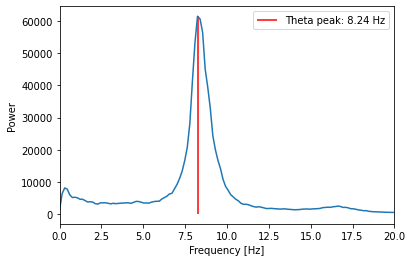

In [92]:
plt.plot(f, channel0)
plt.xlim(0,20)
label = f"Theta peak: {peak_freq:.3} Hz"
plt.vlines(peak_freq, ymin=0, ymax=peak_power, colors='red', label=label)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.legend()
plt.show()